In [2]:
from concurrent.futures import ProcessPoolExecutor, Future
import pandas as pd
import numpy as np
import glob
import re
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from recursive_selection import FeatureSelector
import warnings

# Real World Gambling Test

The attempt to model baseball games with high accuracy has been a total failure so far. However, this may not mean there is not value to be discovered here. The methodology here will be simple: I will generate a model using a the dataset and building on the work of previous modeling notebook (see __01classification_win_loss.ipynb__) but instead of trying to accurately predict every game, I will look for games that have a higher probability of falling into a class (winning) with good value (a __+__ moneyline) and see if the model would have generated profit for a given season. The lesson here may be that there is no real value in trying to predict every game, but picking ones spots may be highly beneficial. 

# Preparing Data

The first challenge is taking historical odds data, which is publicly available at SportsbookReviews.com, and converting into a usable form for this analysis. I have designed a loop below that iterates through the .XSLX files and extracts the data I will need and returns Pandas DataFrames that are ready to merge with the primary dataframe.

In [3]:
#get file paths for MLB betting data
all_files = glob.glob('./historical_odds/*.xlsx')

#create dictionary to store dataframes 
odds_by_season = {}

#iterate over all .XSLX files
for file in all_files:
    #extract year from file name using regex
    match_pattern = '([\d]{4})'
    year = re.findall(match_pattern, file)[0]
    #years before 2014 do not have the run line, will worry about those ones later
    if int(year) < 2014:
        continue
    season_odds = pd.read_excel(file)
    #rename juice columns
    season_odds = season_odds.rename(columns = {'Unnamed: 18' : 'runline_juice',
                                       'Unnamed: 20' : 'total_juice_open',
                                       'Unnamed: 22' : 'total_juice_close'})
    #convert date to str, add in year which is missing, convert date column to datetime object
    season_odds['Date'] = season_odds['Date'].astype('str')
    season_odds['Date'] = season_odds['Date'] + year
    season_odds['Date'] = pd.to_datetime(season_odds['Date'], format = '%m%d%Y')
    #extract meaningful columns
    col_selected = season_odds[['Date', 'VH', 'Team', 'Open', 'Close', 'Run Line', 'runline_juice', 'Open OU',
                               'total_juice_open', 'Close OU', 'total_juice_close']]
    #split frame into neutral, road, and home games
    neutral_site = col_selected[col_selected.VH == 'N'].reset_index(drop = True)
    home_teams = col_selected[col_selected.VH == 'H'].reset_index(drop = True)
    road_teams = col_selected[col_selected.VH == 'V'].reset_index(drop = True)
    
    #rename home and road dataframe feature sets
    home_cols = ['date', 'home_flag', 'team1', 'home_opening', 'home_closing', 'home_runline', 
                'home_runline_juice', 'home_open_ou', 'home_ou_juice_open', 'home_close_ou', 'home_ou_juice_close']
    road_cols = ['date', 'home_flag', 'team2', 'road_opening', 'road_closing', 'road_runline', 
                'road_runline_juice', 'road_open_ou', 'road_ou_juice_open', 'road_close_ou', 'road_ou_juice_close']
    home_teams.columns = home_cols
    road_teams.columns = road_cols
    
    #drop redundant columns (from both), drop date from road frame 
    home_teams = home_teams.drop(columns = ['home_flag'])
    road_teams = road_teams.drop(columns = ['date', 'home_flag'])
    
    #merge home and road datafames
    full_season = pd.concat([home_teams, road_teams], axis = 1)
    
    #add feature for second game of double headers (this is necessary for merging later)
    full_season = full_season.assign(is_doubleheader = 0)
    game_counts = full_season.groupby('team1').date.value_counts()
    double_headers = game_counts[game_counts == 2]

    all_double_headers = []
    for j in double_headers.index:
        all_double_headers.append(j)

    for index in all_double_headers:
        game_indices = full_season[(full_season.team1 == index[0]) & (full_season.date == index[1])].index
        if len(game_indices) > 1:
            full_season.at[game_indices[1], 'is_doubleheader'] = 1
        else:
            print(index)
    #add to dataframe dict
    odds_by_season[year] = full_season

Now that the DataFrames are read in and in the format I want them to be in, I need to prepare the team codes are uniform and will be able to merge with the Elo DataFrame. To do this, I will create a baseline list of team codes used from the MLB odds archive dataframe, and ensure that only those team codes appear in each dataframe. 

In [4]:
#create baseline list of teams
base_teams = odds_by_season['2014'].team1.unique()

#create list to store tuples of problem team codes
problem_teams = []
#iterate through all keys and check for problem team codes (mistyped, changed name, etc.)
for key in odds_by_season.keys():
    home_teams = list(odds_by_season[key].team1.unique())
    road_teams = list(odds_by_season[key].team2.unique())
    for team in home_teams:
        if team not in base_teams:
            problem_teams.append((key, team))
    for team in road_teams:
        if team not in base_teams:
            problem_teams.append((key, team))
#view problem teams
problem_teams

[('2018', 'LAD'),
 ('2018', 'LAD'),
 ('2019', 'LAD'),
 ('2019', 'HOW'),
 ('2019', 'LAD'),
 ('2016', 'LAD')]

It appears that they switched from 'LOS' to 'LAD' for the Dodgers code, and a quick lookup shows that 'HOW' was a mistaken key and was supposed to be 'HOU'. Now, I will replace the problem teams and prepare to compare with the Elo frame. 

In [5]:
#create dict
trouble_dict = {'LOS' : 'LAD',
               'HOW' : 'HOU'}
#iterate through all dataframes
for key in odds_by_season.keys():
    odds_by_season[key] = odds_by_season[key].replace({'team1' : trouble_dict,
                                                      'team2' : trouble_dict})
    print(len(odds_by_season[key].team1.unique()))

30
30
30
30
30
30


Now that the team codes among the new odds DataFrames are consistent, now it is necessary to locate discrepancies between the team codes used in the primary dataframe and the new team codes. In order to do that, I will now read in the primary dataframe, and compare the team codes used in that frame against the new frames.

In [8]:
#read in primary dataframe 
primary_df = pd.read_csv('./all_features.csv.gz', compression = 'gzip')

#prepare primary dataframe 
primary_df['date'] = pd.to_datetime(primary_df['date'], format = '%Y-%m-%d')
primary_df['year'] = pd.DatetimeIndex(primary_df['date']).year
elo_codes = list(primary_df.team1.unique())

In [9]:
#empty list for trouble_elo codes
elo_trouble = []

#iterate through dataframes
for key in odds_by_season.keys():
    team_codes = list(odds_by_season[key].team1.unique())
    for team in team_codes:
        if team not in elo_codes and team not in elo_trouble:
            elo_trouble.append(team)
#view results
elo_trouble

['MIA', 'SDG', 'TAM', 'KAN', 'LAA', 'SFO', 'WAS', 'CWS', 'CUB']

In [10]:
#create dictionary mapping to elo team codes
elo_map = {'WAS' : 'WSN',
         'SDG' : 'SDP',
         'MIA' : 'FLA',
         'TAM' : 'TBD',
         'KAN' : 'KCR',
         'LAA' : 'ANA',
         'SFO' : 'SFG',
         'CWS' : 'CHW',
         'CUB' : 'CHC'}
#iterate through all dataframes
for key in odds_by_season.keys():
    odds_by_season[key] = odds_by_season[key].replace({'team1' : elo_map,
                                                      'team2' : elo_map})
    print(len(odds_by_season[key].team1.unique()))

30
30
30
30
30
30


Now, with the DataFrames fully prepared to merge, I will merge the odds data with the primary dataset. 

In [9]:
#create empty list to store dataframes
completed_frames = []

#create list of merge keys
merge_keys = ['date', 'team1', 'team2', 'is_doubleheader']
#iterate through df dict
for key in odds_by_season.keys():
    season_elo = primary_df[primary_df.year == int(key)].reset_index(drop = True)
    completed = season_elo.merge(odds_by_season[key], how = 'left', left_on = merge_keys, right_on = merge_keys)
    completed_frames.append(completed)
    print(len(completed[completed.home_opening.isnull()]))

0
5
0
4
2
0


The dataframe merging went smoothly, with only 11 games missed. After further observation, these $11$ games were neutral site games, and afer concatenating the frames, I will be dropping these observations. 

In [10]:
#concatenate frames
all_features_with_odds = pd.concat(completed_frames, axis = 0)
#drop rows with null values
all_features_with_odds = all_features_with_odds.dropna(axis = 0, how = 'any')
#sort by date
all_features_with_odds = all_features_with_odds.sort_values(by = ['date']).reset_index(drop = True)
#view frame
all_features_with_odds.head()


,date,is_doubleheader,is_tripleheader,home_OBPS,home_AVG_RUNS,home_AVG_H,home_BULLPEN_ERA,home_BULLPEN_WHIP,home_BULLPEN_AVG_INNINGS,home_total_OBPS,...,home_close_ou,home_ou_juice_close,road_opening,road_closing,road_runline,road_runline_juice,road_open_ou,road_ou_juice_open,road_close_ou,road_ou_juice_close
0,2014-03-30,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.5,-115.0,-105,-115.0,-1.5,150.0,6.5,-120.0,6.5,-105.0
1,2014-03-31,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.5,-120.0,-165,-179.0,-1.5,-105.0,6.5,-115.0,6.5,100.0
2,2014-03-31,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,-106.0,120,130.0,1.5,-175.0,7.0,-105.0,7.0,-114.0
3,2014-03-31,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.5,-105.0,-115,-105.0,1.5,-215.0,8.0,-110.0,7.5,-115.0
4,2014-03-31,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,-125.0,-115,-115.0,-1.5,140.0,8.5,-115.0,9.0,105.0


In [20]:
#isolate vegas features from team based features 
odds_features = list(full_.columns[105:122])
odds_frame = all_features_with_odds[odds_features]
#view datatypes
odds_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14550 entries, 0 to 14549
Data columns (total 16 columns):
home_opening           14550 non-null object
home_closing           14550 non-null float64
home_runline           14550 non-null float64
home_runline_juice     14550 non-null float64
home_open_ou           14550 non-null float64
home_ou_juice_open     14550 non-null float64
home_close_ou          14550 non-null float64
home_ou_juice_close    14550 non-null float64
road_opening           14550 non-null object
road_closing           14550 non-null float64
road_runline           14550 non-null float64
road_runline_juice     14550 non-null float64
road_open_ou           14550 non-null float64
road_ou_juice_open     14550 non-null float64
road_close_ou          14550 non-null float64
road_ou_juice_close    14550 non-null float64
dtypes: float64(14), object(2)
memory usage: 1.8+ MB


For some reason, home opening and road opening lines have been stored as objects. I need to investigate what is happening with these features.

In [21]:
try:
    odds_frame['home_opening'] = odds_frame['home_opening'].astype('int64')
except Exception as e:
    print(e)

invalid literal for int() with base 10: 'NL'


In [22]:
#investigate problem observations
problem_lines = all_features_with_odds[(all_features_with_odds.home_opening == 'NL') |
                                      (all_features_with_odds.road_opening == 'NL')]
#view problem observations
problem_lines

,date,is_doubleheader,is_tripleheader,home_OBPS,home_AVG_RUNS,home_AVG_H,home_BULLPEN_ERA,home_BULLPEN_WHIP,home_BULLPEN_AVG_INNINGS,home_total_OBPS,...,home_close_ou,home_ou_juice_close,road_opening,road_closing,road_runline,road_runline_juice,road_open_ou,road_ou_juice_open,road_close_ou,road_ou_juice_close
12329,2019-04-13,0,0,0.757488,4.666667,8.500000,11.174340,2.327988,3.221667,0.797698,...,9.0,-120.0,NL,109.0,1.5,-195.0,8.5,-110.0,9.0,100.0
12403,2019-04-18,0,0,0.686178,3.777778,7.444444,0.710526,0.710526,4.222222,0.798646,...,8.5,-105.0,NL,220.0,1.5,106.0,8.5,-110.0,8.5,-115.0
12428,2019-04-20,0,0,0.594466,4.166667,6.333333,2.612482,1.112724,3.445000,0.603827,...,8.5,-120.0,NL,124.0,1.5,-180.0,7.5,-110.0,8.5,100.0
12525,2019-04-28,0,0,0.819577,4.900000,9.900000,3.960000,1.460000,5.000000,0.761468,...,8.0,-115.0,NL,-120.0,-1.5,140.0,8.5,-110.0,8.0,-105.0
12568,2019-05-01,0,0,0.748242,5.187500,8.625000,5.883339,1.609118,3.728750,0.736517,...,8.0,-110.0,NL,-220.0,-1.5,-145.0,8.5,-110.0,8.0,-110.0


The opening lines are missing from these games. However, the closing lines are not. Instead of removing the observations, I am going to substitute in the value of the closing line for the opening line.

In [23]:
problem_indices = all_features_with_odds[(all_features_with_odds.home_opening == 'NL') |
                                      (all_features_with_odds.road_opening == 'NL')].index
for index in problem_indices:
    all_features_with_odds.at[index, 'home_opening'] = all_features_with_odds.iloc[index]['home_closing']
    all_features_with_odds.at[index, 'road_opening'] = all_features_with_odds.iloc[index]['road_closing']

In [24]:
#save dataframe
all_features_with_odds.to_csv('./all_features_with_odds.csv.gz', compression = 'gzip', index = False)

# end data prep

In [3]:
#read in prepared DataFrame 
full_ = pd.read_csv('./all_features_with_odds.csv.gz', compression = 'gzip')
#convert date to datetime object
full_['date'] = pd.to_datetime(full_['date'], format = '%Y-%m-%d')

In [4]:
#change pandas option to view all features
pd.set_option('max.columns', 125)
#view frame
full_.head()

,date,is_doubleheader,is_tripleheader,home_OBPS,home_AVG_RUNS,home_AVG_H,home_BULLPEN_ERA,home_BULLPEN_WHIP,home_BULLPEN_AVG_INNINGS,home_total_OBPS,home_total_AVG_RUNS,home_total_AVG_H,home_total_BULLPEN_ERA,home_total_BULLPEN_WHIP,home_total_BULLPEN_AVG_INNINGS,road_OBPS,road_AVG_RUNS,road_AVG_H,road_BULLPEN_ERA,road_BULLPEN_WHIP,road_BULLPEN_AVG_INNINGS,road_total_OBPS,road_total_AVG_RUNS,road_total_AVG_H,road_total_BULLPEN_ERA,road_total_BULLPEN_WHIP,road_total_BULLPEN_AVG_INNINGS,home_starter,home_career_ERA,home_career_WHIP,home_career_AVGIP,home_career_ERA_AH,home_career_WHIP_AH,home_career_AVGIP_AH,home_season_ERA,home_season_WHIP,home_season_AVGIP,home_season_ERA_AH,home_season_WHIP_AH,home_season_AVGIP_AH,road_starter,road_career_ERA,road_career_WHIP,road_career_AVGIP,road_career_ERA_OR,road_career_WHIP_OR,road_career_AVGIP_OR,road_season_ERA,road_season_WHIP,road_season_AVGIP,road_season_ERA_OR,road_season_WHIP_OR,road_season_AVGIP_OR,team1,team2,home_loss,elo1_pre,elo2_pre,elo_prob1,elo_prob2,rating1_pre,rating2_pre,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,score1,score2,pitching_park_factor,batting_park_factor,TMAX,PRCP,SNOW,SNWD,attendance,current_streak_hm_tm,current_streak_hm_at_hm,home_record_hm,run_differential_hm,avg_margin_hm,distance_traveled,current_streak_rd_tm,current_streak_rd_tm_on_rd,rd_record_rd,run_differential_rd,avg_margin_rd,roof_closed,is_retractable,is_wildcard,is_divisional,is_championship,is_world_series,is_daygame,is_march,is_april,is_may,is_june,is_july,is_august,is_september,is_october,is_november,year,home_opening,home_closing,home_runline,home_runline_juice,home_open_ou,home_ou_juice_open,home_close_ou,home_ou_juice_close,road_opening,road_closing,road_runline,road_runline_juice,road_open_ou,road_ou_juice_open,road_close_ou,road_ou_juice_close
0,2014-03-30,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.769012,5.0,9.0,7.109005,2.21169,3.165,0.769012,5.0,9.0,7.109005,2.21169,3.165,casha001,3.215468,1.103347,5.947813,2.528090,1.000000,6.357143,0.0,0.0,0.0,0.0,0.0,0.0,ryu-h001,2.924006,1.187878,6.354516,3.510351,1.200120,6.249375,0.0,0.6,5.0,0.0,0.6,5.0,SDP,LAD,0,1492.867,1537.084,0.470938,0.529062,1491.997,1533.625,53.721,52.503,24.4776,0.1316,0.509215,0.490785,3.0,1.0,92.0,92.0,200.0,0.0,0.0,0.0,45567.0,0.0,0.0,0.0,0.0,0.0,182.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,-105.0,105.0,1.5,-170.0,6.5,100.0,6.5,-115.0,-105.0,-115.0,-1.5,150.0,6.5,-120.0,6.5,-105.0
1,2014-03-31,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000,0.000000,0.0,0.0,0.000000,0.00000,0.000,gee-d001,3.843994,1.297373,6.156790,3.231660,1.235521,6.317073,0.0,0.0,0.0,0.0,0.0,0.0,stras001,2.963253,1.072942,5.790933,3.425824,1.171992,5.704571,0.0,0.0,0.0,0.0,0.0,0.0,NYM,WSN,1,1486.573,1520.297,0.486010,0.513990,1488.144,1520.107,51.389,55.551,5.3580,19.4768,0.474005,0.525995,7.0,9.0,94.0,94.0,133.0,53.0,0.0,0.0,42442.0,0.0,0.0,0.0,0.0,0.0,342.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,145.0,159.0,1.5,-115.0,6.5,-105.0,6.5,-120.0,-165.0,-179.0,-1.5,-105.0,6.5,-115.0,6.5,100.0
2,2014-03-31,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000,0.000000,0.0,0.0,0.000000,0.00000,0.000,grays001,2.850000,1.133333,6.000000,1.991640,0.934350,6.778333,0.0,0.0,0.0,0.0,0.0,0.0,mastj001,4.131346,1.378198,6.157800,4.996183,1.487290,5.922329,0.0,0.0,0.0,0.0,0.0,0.0,OAK,CLE,1,1539.804,1518.841,0.564348,0.435652,1542.484,1520.415,51.444,54.744,0.1833,17.0328,0.547669,0.452331,0.0,2.0,97.0,98.0,139.0,145.0,0.0,0.0,36067.0,0.0,0.0,0.0,0.0,0.0,3466.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014,-135.0,-145.0,-1.5,155.0,7.0,-115.0,7.0,-106.0,120.0,130.0,1.5,-175.0,7.0,-105.0,7.0,-114.0
3,2014-03-31,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0

In [5]:
#isolate vegas features from team based features 
odds_features = list(full_.columns[105:122])

In [6]:
odds_features

['home_opening',
 'home_closing',
 'home_runline',
 'home_runline_juice',
 'home_open_ou',
 'home_ou_juice_open',
 'home_close_ou',
 'home_ou_juice_close',
 'road_opening',
 'road_closing',
 'road_runline',
 'road_runline_juice',
 'road_open_ou',
 'road_ou_juice_open',
 'road_close_ou',
 'road_ou_juice_close']

# Experiment with predicting power using only odds, no team statistics whatsoever

In [7]:
#isolate odds 
odds_frame = full_[odds_features]

In [8]:
#view potential features
odds_frame.head()

,home_opening,home_closing,home_runline,home_runline_juice,home_open_ou,home_ou_juice_open,home_close_ou,home_ou_juice_close,road_opening,road_closing,road_runline,road_runline_juice,road_open_ou,road_ou_juice_open,road_close_ou,road_ou_juice_close
0,-105.0,105.0,1.5,-170.0,6.5,100.0,6.5,-115.0,-105.0,-115.0,-1.5,150.0,6.5,-120.0,6.5,-105.0
1,145.0,159.0,1.5,-115.0,6.5,-105.0,6.5,-120.0,-165.0,-179.0,-1.5,-105.0,6.5,-115.0,6.5,100.0
2,-135.0,-145.0,-1.5,155.0,7.0,-115.0,7.0,-106.0,120.0,130.0,1.5,-175.0,7.0,-105.0,7.0,-114.0
3,105.0,-105.0,-1.5,185.0,8.0,-110.0,7.5,-105.0,-115.0,-105.0,1.5,-215.0,8.0,-110.0,7.5,-115.0
4,105.0,105.0,1.5,-160.0,8.5,-105.0,9.0,-125.0,-115.0,-115.0,-1.5,140.0,8.5,-115.0,9.0,105.0


In [9]:
#get target features from full dataframe, concatentate them to my dataframe 
targets = full_[['home_loss', 'score1', 'score2']]
odds_frame = pd.concat([odds_frame, targets], axis = 1)

In [10]:
#create score differential and total feature to look into modeling with runline
odds_frame['score_differential'] = odds_frame['score1'] - odds_frame['score2']
odds_frame['game_total'] = odds_frame['score1'] + odds_frame['score2']
#get rid of score1 and score2 column
odds_frame = odds_frame.drop(columns = ['score1', 'score2'])

In [11]:
odds_frame.head()

,home_opening,home_closing,home_runline,home_runline_juice,home_open_ou,home_ou_juice_open,home_close_ou,home_ou_juice_close,road_opening,road_closing,road_runline,road_runline_juice,road_open_ou,road_ou_juice_open,road_close_ou,road_ou_juice_close,home_loss,score_differential,game_total
0,-105.0,105.0,1.5,-170.0,6.5,100.0,6.5,-115.0,-105.0,-115.0,-1.5,150.0,6.5,-120.0,6.5,-105.0,0,2.0,4.0
1,145.0,159.0,1.5,-115.0,6.5,-105.0,6.5,-120.0,-165.0,-179.0,-1.5,-105.0,6.5,-115.0,6.5,100.0,1,-2.0,16.0
2,-135.0,-145.0,-1.5,155.0,7.0,-115.0,7.0,-106.0,120.0,130.0,1.5,-175.0,7.0,-105.0,7.0,-114.0,1,-2.0,2.0
3,105.0,-105.0,-1.5,185.0,8.0,-110.0,7.5,-105.0,-115.0,-105.0,1.5,-215.0,8.0,-110.0,7.5,-115.0,1,-4.0,24.0
4,105.0,105.0,1.5,-160.0,8.5,-105.0,9.0,-125.0,-115.0,-115.0,-1.5,140.0,8.5,-115.0,9.0,105.0,0,1.0,3.0


Now that I have score differential and game total, before generating regression models on this data, I will start with binary classification to determine if the home team covered and if the total went over.

In [12]:
class CoverCalculator():
    def __init__(self, df):
        self.df = df
        self.home_runline_cover = []
        self.total_over = []
        
    def runline_cover(self):
        for k in range(len(self.df)):
            if self.df.iloc[k]['home_runline'] < 0:
                if self.df.iloc[k]['score_differential'] >= (-1 * self.df.iloc[k]['home_runline']):
                    self.home_runline_cover.append(1)
                else:
                    self.home_runline_cover.append(0)
            else:
                if self.df.iloc[k]['home_loss'] == 0:
                    self.home_runline_cover.append(1)
                elif (-1 * self.df.iloc[k]['score_differential']) < self.df.iloc[k]['home_runline']:
                    self.home_runline_cover.append(1)
                else:
                    self.home_runline_cover.append(0)
        return(self.home_runline_cover)
    
    def over(self):
        for k in range(len(self.df)):
            if self.df.iloc[k]['home_close_ou'] < self.df.iloc[k]['game_total']:
                self.total_over.append(1)
            else:
                self.total_over.append(0)
        return(self.total_over)

In [13]:
#iterate through dataframe and calculate binary target variables
calc = CoverCalculator(odds_frame)
runline_covers = calc.runline_cover()
totals = calc.over()

In [14]:
#create series objects and concatenate them to dataframe 
runline_covers = pd.Series(runline_covers)
totals = pd.Series(totals)
odds_frame = pd.concat([odds_frame, runline_covers, totals], axis = 1)

In [15]:
#rename new columns
odds_frame = odds_frame.rename(columns = {0 : 'home_runline_cover', 1 : 'over_hit'})

In [16]:
#drop redundant columns
odds_frame = odds_frame.drop(columns = ['road_open_ou', 'road_ou_juice_open', 'road_close_ou',
                                       'road_ou_juice_close'])
odds_frame = odds_frame.rename(columns = {'home_open_ou' : 'opening_total', 'home_ou_juice_open' : 'total_juice_open',
                                         'home_close_ou' : 'closing_total', 'home_ou_juice_close' : 'total_juice_close'})

In [17]:
#drop regression targets 
odds_frame = odds_frame.drop(columns = ['score_differential', 'game_total'])

In [18]:
#extract modeling features from potential targets
X = odds_frame.drop(columns = ['home_loss', 'home_runline_cover', 'over_hit'])
y1 = odds_frame['home_loss']
y2 = odds_frame['home_runline_cover']
y3 = odds_frame['over_hit']

## Baseline Modeling

In [19]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y1, test_size = 0.25, random_state = 43)
lr = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
lr.fit(xtrain, ytrain)
y_preds = lr.predict(xtest)
print('Baseline win/loss accuracy {}'.format(accuracy_score(ytest, y_preds)))

Baseline win/loss accuracy 0.5678944474986256


In [20]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y2, test_size = 0.25, random_state = 43)
lr = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
lr.fit(xtrain, ytrain)
y_preds = lr.predict(xtest)
print('Baseline win/loss accuracy {}'.format(accuracy_score(ytest, y_preds)))

Baseline win/loss accuracy 0.5907091808686091


In [21]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y3, test_size = 0.25, random_state = 43)
lr = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
lr.fit(xtrain, ytrain)
y_preds = lr.predict(xtest)
print('Baseline win/loss accuracy {}'.format(accuracy_score(ytest, y_preds)))

Baseline win/loss accuracy 0.5277625068719076


In [22]:
#check feature subsets
selector = FeatureSelector(X, y2, algorithm = LGBMClassifier(), params = {'max_depth' : 5, 'num_leaves' : 50},
                          verbose = 2)
selector.recursive_selection()

2 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration


'Cannot reduce feature frame anymore. Reduce drop size if desired'

In [23]:
selector.best_subset

Index(['home_opening', 'home_closing', 'home_runline_juice'], dtype='object')

This did not yield any more or less predictive power, but I will note these three features as potentially useful to add on to the feature set I eventually use.

Detour to determine which statistics (if any) are relevant in predicting win/loss, covering runline, etc. 

In [24]:
non_odds_features = list(full_.columns[:105])
no_odds_frame = full_[non_odds_features]

In [25]:
no_odds_frame = no_odds_frame.drop(columns = ['date', 'is_doubleheader', 'is_tripleheader', 'home_starter',
                                             'road_starter', 'team1', 'team2', 'home_loss', 'score1', 'score2',
                                             'roof_closed', 'is_retractable', 'is_wildcard', 'is_divisional',
                                             'is_championship', 'is_world_series', 'is_daygame', 'is_march',
                                             'is_april', 'is_may', 'is_june', 'is_july', 'is_august', 'is_september',
                                             'is_october', 'is_november', 'year'])
no_odds_frame.head()

,home_OBPS,home_AVG_RUNS,home_AVG_H,home_BULLPEN_ERA,home_BULLPEN_WHIP,home_BULLPEN_AVG_INNINGS,home_total_OBPS,home_total_AVG_RUNS,home_total_AVG_H,home_total_BULLPEN_ERA,home_total_BULLPEN_WHIP,home_total_BULLPEN_AVG_INNINGS,road_OBPS,road_AVG_RUNS,road_AVG_H,road_BULLPEN_ERA,road_BULLPEN_WHIP,road_BULLPEN_AVG_INNINGS,road_total_OBPS,road_total_AVG_RUNS,road_total_AVG_H,road_total_BULLPEN_ERA,road_total_BULLPEN_WHIP,road_total_BULLPEN_AVG_INNINGS,home_career_ERA,home_career_WHIP,home_career_AVGIP,home_career_ERA_AH,home_career_WHIP_AH,home_career_AVGIP_AH,home_season_ERA,home_season_WHIP,home_season_AVGIP,home_season_ERA_AH,home_season_WHIP_AH,home_season_AVGIP_AH,road_career_ERA,road_career_WHIP,road_career_AVGIP,road_career_ERA_OR,road_career_WHIP_OR,road_career_AVGIP_OR,road_season_ERA,road_season_WHIP,road_season_AVGIP,road_season_ERA_OR,road_season_WHIP_OR,road_season_AVGIP_OR,elo1_pre,elo2_pre,elo_prob1,elo_prob2,rating1_pre,rating2_pre,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,pitching_park_factor,batting_park_factor,TMAX,PRCP,SNOW,SNWD,attendance,current_streak_hm_tm,current_streak_hm_at_hm,home_record_hm,run_differential_hm,avg_margin_hm,distance_traveled,current_streak_rd_tm,current_streak_rd_tm_on_rd,rd_record_rd,run_differential_rd,avg_margin_rd
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.769012,5.0,9.0,7.109005,2.21169,3.165,0.769012,5.0,9.0,7.109005,2.21169,3.165,3.215468,1.103347,5.947813,2.528090,1.000000,6.357143,0.0,0.0,0.0,0.0,0.0,0.0,2.924006,1.187878,6.354516,3.510351,1.200120,6.249375,0.0,0.6,5.0,0.0,0.6,5.0,1492.867,1537.084,0.470938,0.529062,1491.997,1533.625,53.721,52.503,24.4776,0.1316,0.509215,0.490785,92.0,92.0,200.0,0.0,0.0,0.0,45567.0,0.0,0.0,0.0,0.0,0.0,182.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000,0.000000,0.0,0.0,0.000000,0.00000,0.000,3.843994,1.297373,6.156790,3.231660,1.235521,6.317073,0.0,0.0,0.0,0.0,0.0,0.0,2.963253,1.072942,5.790933,3.425824,1.171992,5.704571,0.0,0.0,0.0,0.0,0.0,0.0,1486.573,1520.297,0.486010,0.513990,1488.144,1520.107,51.389,55.551,5.3580,19.4768,0.474005,0.525995,94.0,94.0,133.0,53.0,0.0,0.0,42442.0,0.0,0.0,0.0,0.0,0.0,342.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000,0.000000,0.0,0.0,0.000000,0.00000,0.000,2.850000,1.133333,6.000000,1.991640,0.934350,6.778333,0.0,0.0,0.0,0.0,0.0,0.0,4.131346,1.378198,6.157800,4.996183,1.487290,5.922329,0.0,0.0,0.0,0.0,0.0,0.0,1539.804,1518.841,0.564348,0.435652,1542.484,1520.415,51.444,54.744,0.1833,17.0328,0.547669,0.452331,97.0,98.0,139.0,145.0,0.0,0.0,36067.0,0.0,0.0,0.0,0.0,0.0,3466.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000,0.000000,0.0,0.0,0.000000,0.00000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.517918,1.188584,6.654952,3.687615,1.202648,6.548696,0.0,0.0,0.0,0.0,0.0,0.0,1526.809,1477.388,0.604116,0.395884,1528.187,1475.318,47.400,59.728,-19.7635,49.6837,0.514708,0.485292,104.0,104.0,272.0,0.0,0.0,0.0,49031.0,0.0,0.0,0.0,0.0,0.0,2113.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000,0.000000,0.0,0.0,0.000000,0.00000,0.000,4.261886,1.325497,5.631310,4.250521,1.301961,5.732439,0.0,0.0,0.0,0.0,0.0,0.0,3.769387,1.305179,6.251318,3.738755,1.276514,6.213504,0.0,0.0,0.0,0.0,0.0,0.0,1516.659,1558.985,0.473651,0.526349,1514.563,1558.601,54.138,57.534,21.0466,26.4422,0.466616,0.533384,103.0,103.0,183.0,0.0,0.0,0.0,30155.0,0.0,0.0,0.0,0.0,0.0,576.0,0.0,0.0,0.0,0.0,0.0


The greatest challenge of this work is selecting which, if any features, have a good predictive power. Thus far, I have not been able to isolate a feature set that is able to establish a decision boundary in Win/Loss classification, Score Differential regression, Runline Cover classification, or Total Over classification. My methodology has been centeredd on feature importance, with little success. I have isolated features into categories of feature to determine if any subset of these features will yield a usable decision boundary, and then I will begin adding subsets of features together to determine if there is interaction between subsets that can yield predictive power.

In [26]:
stat_cols = pd.Series(no_odds_frame.columns)
OBPS = list(stat_cols[stat_cols.str.contains('OBPS')].values)
RUNS = list(stat_cols[stat_cols.str.contains('RUNS')].values)
HITS = list(stat_cols[stat_cols.str.contains('AVG_H')].values)
STARTER_ERA = list(stat_cols[(stat_cols.str.contains('ERA')) & ~(stat_cols.str.contains('BULLPEN'))].values)
STARTER_WHIP = list(stat_cols[(stat_cols.str.contains("WHIP")) & ~(stat_cols.str.contains("BULLPEN"))].values)
STARTER_AVGIP = list(stat_cols[stat_cols.str.contains("AVGIP")].values)
BULLPEN_ERA = list(stat_cols[(stat_cols.str.contains('ERA')) & (stat_cols.str.contains('BULLPEN'))].values)
BULLPEN_WHIP = list(stat_cols[(stat_cols.str.contains("WHIP")) & (stat_cols.str.contains("BULLPEN"))].values)
BULLPEN_AVGIP = list(stat_cols[stat_cols.str.contains("AVG_INNINGS")].values)
ELORatings = ['elo1_pre', 'elo2_pre']
ADJRatings = ['rating1_pre', 'rating2_pre']
PITCHERratings = ['pitcher1_rgs', 'pitcher2_rgs', 'pitcher1_adj', 'pitcher2_adj']
ELOProbs = ['elo_prob1', 'elo_prob2']
ADJProbs = ['rating_prob1', 'rating_prob2']
EXTERNALS = list(stat_cols.iloc[60:67].values)
MOMENTUM = list(stat_cols.iloc[67:].values)

eval_dict = {'OBPS' : OBPS,
            'RUNS' : RUNS,
            'HITS' : HITS,
            'STARTER_ERA' : STARTER_ERA,
            'STARTER_WHIP' : STARTER_WHIP,
            'STARTER_AVGIP' : STARTER_AVGIP,
            'BULLPEN_ERA' : BULLPEN_ERA,
            'BULLPEN_WHIP' : BULLPEN_WHIP,
            'BULLPEN_AVGIP' : BULLPEN_AVGIP,
            'ELORatings' : ELORatings,
            'ADJRatings' : ADJRatings,
            'PITCHERratings' : PITCHERratings,
            'ELOProbs' : ELOProbs,
            'ADJProbs' : ADJProbs,
            'EXTERNALS' : EXTERNALS,
            'MOMENTUM' : MOMENTUM}

In [44]:
class SubsetSampler():
    def __init__(self, X, y, all_subsets, algorithm = LogisticRegression(), eval_type = 'roc', params = None,
                 n_jobs = None, cv = 5, VIF = False, vif_tolerance = 5.0):
        self.X = X
        self.y = y
        self.all_subsets = all_subsets
        self.algorithm = algorithm
        self.eval_type = eval_type
        self.params = params
        self.n_jobs = n_jobs
        self.cv = cv
        self.vif_tolerance = vif_tolerance
        self.VIF = VIF
        self.evals = []
        self.current_eval = 0.0
        self.best_eval = 0.0
        self.current_feature_set = None
        self.best_feature_set = None
        self.results_list = []
        self.results_frame = None
    
    def feature_search(self):
        self.sample()
        self.results_frame = self.results_frame.sort_values(by = ['score'], ascending = False)
        for j in range(1, len(self.results_frame)):
            self.current_feature_set = list(self.best_feature_set)
            self.current_feature_set += self.all_subsets[self.results_frame.iloc[j]['category']]
            self.cross_validate()
            if self.current_eval >= self.best_eval:
                self.best_feature_set = self.current_feature_set
                self.best_eval = self.current_eval
            else:
                continue
        
    def sample(self):
        for category in self.all_subsets.keys():
            self.current_feature_set = self.all_subsets[category]
            self.cross_validate()
            if self.current_eval >= self.best_eval:
                self.best_eval = self.current_eval
                self.best_feature_set = self.current_feature_set
            self.results_list.append(self.current_eval)
        self.results_frame = pd.DataFrame({'category' : list(self.all_subsets.keys()), 'score' : self.results_list})
    
    def cross_validate(self):
        X_ = self.X[self.current_feature_set]
        if self.VIF:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                to_drop = self.calculate_vif(X_, self.vif_tolerance)
                X_ = X_.drop(columns = to_drop)
                self.current_feature_set = X_.columns
        kf = KFold(n_splits = self.cv)
        results = []
        with ProcessPoolExecutor(max_workers = self.n_jobs) as executor:
            for train, test in kf.split(X_):
                xtrain, xtest = X_.iloc[train], X_.iloc[test]
                ytrain, ytest = self.y.iloc[train], self.y.iloc[test]
                score = self.train_test_eval(xtrain, xtest, ytrain, ytest, self.algorithm,
                                             self.eval_type, self.params)
                results.append(score / self.cv)
        self.current_eval = sum(results)
            
    @staticmethod
    def train_test_eval(xtrain, xtest, ytrain, ytest, algorithm, eval_type, params):
        if params:
            algo = algorithm.set_params(**params)
        else:
            algo = algorithm
        algo.fit(xtrain, ytrain)
        ypreds = algo.predict(xtest)
        if eval_type == 'roc':
            score = roc_auc_score(ytest, ypreds)
        elif eval_type == 'accuracy':
            score = accuracy_score(ytest, ypreds)
        elif eval_type == 'precision':
            score = precision_score(ytest, ypreds)
        return(score)
        
    @staticmethod
    def calculate_vif(X, tol):
        dropped_list = []
        while True:
            X = X.assign(constant = 1)
            X_cols = list(X.columns)
            npX = np.array(X)
            vif = [variance_inflation_factor(npX, i) for i in np.arange(npX.shape[1])]
            vif_ = pd.Series(vif, index = X_cols)
            vif_ = vif_.drop('constant')
            max_vif = vif_.idxmax()
            if vif_.max() > tol:
                X = X.drop(columns = [max_vif, 'constant'])
                dropped_list.append(max_vif)
            else:
                return(dropped_list)
        

In [28]:
all_results = []
for target in(y1, y2, y3):
    sampler = SubsetSampler(no_odds_frame, target, eval_dict, params = {'solver' : 'lbfgs', 'max_iter' : 1000},
                           VIF = True)
    sampler.sample()
    all_results.append(sampler.results_frame)
frame = pd.concat(all_results, axis = 1)
frame.columns = ['category', 'win_loss_score', 'DROP1', 'runline_score', 'DROP2', 'total_score']
frame = frame.drop(columns = ['DROP1', 'DROP2'])
frame

,category,win_loss_score,runline_score,total_score
0,OBPS,0.513234,0.499649,0.498950
1,RUNS,0.517848,0.499094,0.498941
2,HITS,0.502409,0.499503,0.499968
3,STARTER_ERA,0.502093,0.499793,0.499969
4,STARTER_WHIP,0.501922,0.499715,0.499903
5,STARTER_AVGIP,0.509161,0.500102,0.502802
6,BULLPEN_ERA,0.510143,0.499755,0.499492
7,BULLPEN_WHIP,0.513517,0.500131,0.499266
8,BULLPEN_AVGIP,0.506181,0.501834,0.501060
9,ELORatings,0.550860,0.500312,0.500000


Investigating win/loss shows the most promise so this is the one I will pursue. I will add in groups of features that performed well. I have tried recursive removal, this is a last ditch effort where I will try recursive addition.

In [29]:
#generate list of all features
all_features = pd.Series(no_odds_frame.columns)
#split into list of home/road features, collected from retrosheet
home_team_retro = all_features[all_features.str.contains('home')]
road_team_retro = all_features[all_features.str.contains('road')]
#split into list of home/road features, collected from elo dataset
home_team_elo = all_features[all_features.str.contains('1')]
road_team_elo = all_features[all_features.str.contains('2')]

In [30]:
#check lengths of features
len(home_team_retro), len(road_team_retro), len(home_team_elo), len(road_team_elo)

(25, 24, 6, 6)

In [31]:
#view the series that is too long and determine which feature should not be there
home_team_retro

0                          home_OBPS
1                      home_AVG_RUNS
2                         home_AVG_H
3                   home_BULLPEN_ERA
4                  home_BULLPEN_WHIP
5           home_BULLPEN_AVG_INNINGS
6                    home_total_OBPS
7                home_total_AVG_RUNS
8                   home_total_AVG_H
9             home_total_BULLPEN_ERA
10           home_total_BULLPEN_WHIP
11    home_total_BULLPEN_AVG_INNINGS
24                   home_career_ERA
25                  home_career_WHIP
26                 home_career_AVGIP
27                home_career_ERA_AH
28               home_career_WHIP_AH
29              home_career_AVGIP_AH
30                   home_season_ERA
31                  home_season_WHIP
32                 home_season_AVGIP
33                home_season_ERA_AH
34               home_season_WHIP_AH
35              home_season_AVGIP_AH
69                    home_record_hm
dtype: object

In [32]:
#home_record is showing up in home_team_features, dropping from axis 
home_team_retro = home_team_retro.drop(69, axis = 0)

In [33]:
#reset indices, combine like series into dataframe to look at feature names together
home_team_retro = home_team_retro.reset_index(drop = True)
road_team_retro = road_team_retro.reset_index(drop = True)
home_team_elo = home_team_elo.reset_index(drop = True)
road_team_elo = road_team_elo.reset_index(drop = True)

#concat retro features together to examine side by side
pd.concat([home_team_retro, road_team_retro, home_team_elo, road_team_elo], axis = 1)

,0,1,2,3
0,home_OBPS,road_OBPS,elo1_pre,elo2_pre
1,home_AVG_RUNS,road_AVG_RUNS,elo_prob1,elo_prob2
2,home_AVG_H,road_AVG_H,rating1_pre,rating2_pre
3,home_BULLPEN_ERA,road_BULLPEN_ERA,pitcher1_rgs,pitcher2_rgs
4,home_BULLPEN_WHIP,road_BULLPEN_WHIP,pitcher1_adj,pitcher2_adj
5,home_BULLPEN_AVG_INNINGS,road_BULLPEN_AVG_INNINGS,rating_prob1,rating_prob2
6,home_total_OBPS,road_total_OBPS,NaN,NaN
7,home_total_AVG_RUNS,road_total_AVG_RUNS,NaN,NaN
8,home_total_AVG_H,road_total_AVG_H,NaN,NaN
9,home_total_BULLPEN_ERA,road_total_BULLPEN_ERA,NaN,NaN


In [34]:
#remove odds features that are perfectly collinear, prepare dataset to get discrepancies
no_odds_frame = no_odds_frame.drop(columns = ['elo_prob2', 'rating_prob2'])
#removed dropped columns from features to iterate over 
home_team_elo = home_team_elo.drop([1, 5], axis = 0)
road_team_elo = road_team_elo.drop([1, 5], axis = 0)

In [35]:
#create empty list to store series of stat differences (retrosheet)
all_series = []
#col names (retro)
column_names = []

#iterate through feature series, storing differential in all_series
#to keep consistency with target variable, it will be (home value - road value), as target is (home_score - road_score)
for j in range(len(home_team_retro)):
    home_stat = home_team_retro.iloc[j]
    #some stat names are formatted differently between home and road, account for those 
    if home_stat.split('_')[-1] != 'AH':
        stat_category = home_stat.split('home')[1]
        road_stat = '{}{}'.format('road', stat_category)
        difference = no_odds_frame[home_stat] - no_odds_frame[road_stat]
    else:
        stat_category = home_stat.split('home')[1].split('AH')[0]
        road_stat = '{}{}{}'.format('road', stat_category, 'OR')
        difference = no_odds_frame[home_stat] - no_odds_frame[road_stat]
    all_series.append(difference)
    column_names.append(stat_category)
#iterate through elo feature series
for j in range(len(home_team_elo)):
    home_stat = home_team_elo.iloc[j]
    if home_stat.split('1')[1] != '':
        stat_category = home_stat.split('1')[0] + '{}' + home_stat.split('1')[1]
    else:
        stat_category = home_stat.split('1')[0] + '{}'
    road_stat = stat_category.format('2')
    difference = no_odds_frame[home_stat] - no_odds_frame[road_stat]
    stat_category = stat_category.replace('{}', '')
    all_series.append(difference)
    column_names.append(stat_category)

#aggregate all series into dataframe     
difference_frame = pd.concat(all_series, axis = 1)
difference_frame.columns = column_names
#view dataframe
difference_frame.head()

,_OBPS,_AVG_RUNS,_AVG_H,_BULLPEN_ERA,_BULLPEN_WHIP,_BULLPEN_AVG_INNINGS,_total_OBPS,_total_AVG_RUNS,_total_AVG_H,_total_BULLPEN_ERA,_total_BULLPEN_WHIP,_total_BULLPEN_AVG_INNINGS,_career_ERA,_career_WHIP,_career_AVGIP,_career_ERA_,_career_WHIP_,_career_AVGIP_,_season_ERA,_season_WHIP,_season_AVGIP,_season_ERA_,_season_WHIP_,_season_AVGIP_,elo_pre,rating_pre,pitcher_rgs,pitcher_adj
0,-0.769012,-5.0,-9.0,-7.109005,-2.21169,-3.165,-0.769012,-5.0,-9.0,-7.109005,-2.21169,-3.165,0.291462,-0.084531,-0.406704,-0.982261,-0.200120,0.107768,0.0,-0.6,-5.0,0.0,-0.6,-5.0,-44.217,-41.628,1.218,24.3460
1,0.000000,0.0,0.0,0.000000,0.00000,0.000,0.000000,0.0,0.0,0.000000,0.00000,0.000,0.880741,0.224432,0.365857,-0.194164,0.063529,0.612502,0.0,0.0,0.0,0.0,0.0,0.0,-33.724,-31.963,-4.162,-14.1188
2,0.000000,0.0,0.0,0.000000,0.00000,0.000,0.000000,0.0,0.0,0.000000,0.00000,0.000,-1.281346,-0.244865,-0.157800,-3.004543,-0.552940,0.856005,0.0,0.0,0.0,0.0,0.0,0.0,20.963,22.069,-3.300,-16.8495
3,0.000000,0.0,0.0,0.000000,0.00000,0.000,0.000000,0.0,0.0,0.000000,0.00000,0.000,-3.517918,-1.188584,-6.654952,-3.687615,-1.202648,-6.548696,0.0,0.0,0.0,0.0,0.0,0.0,49.421,52.869,-12.328,-69.4472
4,0.000000,0.0,0.0,0.000000,0.00000,0.000,0.000000,0.0,0.0,0.000000,0.00000,0.000,0.492499,0.020318,-0.620009,0.511766,0.025448,-0.481065,0.0,0.0,0.0,0.0,0.0,0.0,-42.326,-44.038,-3.396,-5.3956


In [36]:
#generate list of all features from original frame not included in updated frame 
not_head2head = list(all_features[~(all_features.str.contains('home')) & ~(all_features.str.contains('road')) &
                                  ~(all_features.str.contains('1')) & ~(all_features.str.contains('2'))].values) \
+ ['elo_prob1', 'rating_prob1']

#generate partial frame from original frame using selected columns 
add_on = no_odds_frame[not_head2head]

#insure frames are same length
len(difference_frame), len(add_on)

(14550, 14550)

In [37]:
#concatenate both frames into a single frame 
updated_X = pd.concat([difference_frame, add_on, no_odds_frame['home_record_hm']], axis = 1)

In [38]:
stat_cols = pd.Series(X.columns)
OBPS = list(stat_cols[stat_cols.str.contains('OBPS')].values)
RUNS = list(stat_cols[stat_cols.str.contains('RUNS')].values)
HITS = list(stat_cols[stat_cols.str.contains('AVG_H')].values)
STARTER_ERA = list(stat_cols[(stat_cols.str.contains('ERA')) & ~(stat_cols.str.contains('BULLPEN'))].values)
STARTER_WHIP = list(stat_cols[(stat_cols.str.contains("WHIP")) & ~(stat_cols.str.contains("BULLPEN"))].values)
STARTER_AVGIP = list(stat_cols[stat_cols.str.contains("AVGIP")].values)
BULLPEN_ERA = list(stat_cols[(stat_cols.str.contains('ERA')) & (stat_cols.str.contains('BULLPEN'))].values)
BULLPEN_WHIP = list(stat_cols[(stat_cols.str.contains("WHIP")) & (stat_cols.str.contains("BULLPEN"))].values)
BULLPEN_AVGIP = list(stat_cols[stat_cols.str.contains("AVG_INNINGS")].values)
ELORatings = ['elo_pre']
ADJRatings = ['rating_pre']
PITCHERratings = ['pitcher_rgs', 'pitcher_adj']
ELOProbs = ['elo_prob1']
ADJProbs = ['rating_prob1']
EXTERNALS = list(stat_cols.iloc[28:35].values)
MOMENTUM = list(stat_cols.iloc[35:45].values) + [stat_cols.iloc[47]]

discrepancy_dict = {'OBPS' : OBPS,
            'RUNS' : RUNS,
            'HITS' : HITS,
            'STARTER_ERA' : STARTER_ERA,
            'STARTER_WHIP' : STARTER_WHIP,
            'STARTER_AVGIP' : STARTER_AVGIP,
            'BULLPEN_ERA' : BULLPEN_ERA,
            'BULLPEN_WHIP' : BULLPEN_WHIP,
            'BULLPEN_AVGIP' : BULLPEN_AVGIP,
            'ELORatings' : ELORatings,
            'ADJRatings' : ADJRatings,
            'PITCHERratings' : PITCHERratings,
            'ELOProbs' : ELOProbs,
            'ADJProbs' : ADJProbs,
            'EXTERNALS' : EXTERNALS,
            'MOMENTUM' : MOMENTUM}

In [39]:
def moneyline_movement(opening, closing, frame):
    moneyline_moves = []
    for k in range(len(frame)):
        move = frame.iloc[k][closing] - frame.iloc[k][opening]
        if (frame.iloc[k][opening] < 0 and frame.iloc[k][closing] > 0) or \
        (frame.iloc[k][opening] > 0 and frame.iloc[k][closing] < 0):
            if move < 0:
                move += 200
            else:
                move -= 200
        moneyline_moves.append(move)
    return(pd.Series(moneyline_moves))

In [40]:
#calculate home moneyline movement
home_ML_moves = moneyline_movement('home_opening', 'home_closing', odds_frame)
odds_frame = pd.concat([odds_frame, home_ML_moves], axis = 1)
odds_frame = odds_frame.rename(columns = {0 : 'moneyline_movement'})

NameError: name 'odds_frame' is not defined

In [41]:
#get odds columns 
MONEYLINE = ['home_opening', 'home_closing', 'moneyline_movement']
RUNLINE = ['home_runline', 'home_runline_juice', 'road_runline_juice']
TOTAL = ['opening_total', 'total_juice_open', 'closing_total', 'total_juice_close']

In [42]:
keepers = MONEYLINE + RUNLINE + TOTAL
odds_ = odds_frame[keepers].reset_index(drop = True)
odds_.head()

,home_opening,home_closing,moneyline_movement,home_runline,home_runline_juice,road_runline_juice,opening_total,total_juice_open,closing_total,total_juice_close
0,-105.0,105.0,10.0,1.5,-170.0,150.0,6.5,100.0,6.5,-115.0
1,145.0,159.0,14.0,1.5,-115.0,-105.0,6.5,-105.0,6.5,-120.0
2,-135.0,-145.0,-10.0,-1.5,155.0,-175.0,7.0,-115.0,7.0,-106.0
3,105.0,-105.0,-10.0,-1.5,185.0,-215.0,8.0,-110.0,7.5,-105.0
4,105.0,105.0,0.0,1.5,-160.0,140.0,8.5,-105.0,9.0,-125.0


In [42]:
#add odds categories to the dictionary of discrepancies 
odds_dict = {'MONEYLINE' : MONEYLINE,
            'RUNLINE' : RUNLINE,
            'TOTAL' : TOTAL}
discrepancy_dict.update(odds_dict)

In [44]:
#add in odds features to feature frame 
updated_X = pd.concat([updated_X, odds_], axis = 1)

In [45]:
#iterate through features
all_results = []
for target in(y1, y2, y3):
    sampler = SubsetSampler(updated_X, target, discrepancy_dict, params = {'solver' : 'lbfgs', 'max_iter' : 1000},
                           VIF = True)
    sampler.sample()
    all_results.append(sampler.results_frame)
frame = pd.concat(all_results, axis = 1)
frame.columns = ['category', 'win_loss_score', 'DROP1', 'runline_score', 'DROP2', 'total_score']
frame = frame.drop(columns = ['DROP1', 'DROP2'])
frame

,category,win_loss_score,runline_score,total_score
0,OBPS,0.512540,0.499804,0.499961
1,RUNS,0.515028,0.499192,0.499867
2,HITS,0.501750,0.499454,0.500431
3,STARTER_ERA,0.503630,0.499363,0.499261
4,STARTER_WHIP,0.501374,0.499205,0.499913
5,STARTER_AVGIP,0.508506,0.499995,0.499949
6,BULLPEN_ERA,0.511117,0.499834,0.500343
7,BULLPEN_WHIP,0.514253,0.500109,0.500442
8,BULLPEN_AVGIP,0.506396,0.502007,0.500541
9,ELORatings,0.550584,0.500311,0.500000


In [46]:
sampler = SubsetSampler(updated_X, y1, discrepancy_dict, params = {'solver' : 'lbfgs', 'max_iter' : 1000},
                       VIF = True)
sampler.feature_search()
#save sampler feature set when performed with VIF
with_VIF_ML = list(sampler.best_feature_set)

In [47]:
sampler = SubsetSampler(updated_X, y2, discrepancy_dict, params = {'solver' : 'lbfgs', 'max_iter' : 1000},
                       VIF = True)
sampler.feature_search()
#save runline features
with_VIF_RL = list(sampler.best_feature_set)

In [48]:
sampler = SubsetSampler(updated_X, y1, discrepancy_dict, params = {'solver' : 'lbfgs', 'max_iter' : 1000})
sampler.feature_search()
without_VIF_ML = sampler.best_feature_set

In [49]:
sampler = SubsetSampler(updated_X, y2, discrepancy_dict, params = {'solver' : 'lbfgs', 'max_iter' : 1000})
sampler.feature_search()
#save runline features
without_VIF_RL = list(sampler.best_feature_set)

In [50]:
updated_X.describe()

,_OBPS,_AVG_RUNS,_AVG_H,_BULLPEN_ERA,_BULLPEN_WHIP,_BULLPEN_AVG_INNINGS,_total_OBPS,_total_AVG_RUNS,_total_AVG_H,_total_BULLPEN_ERA,_total_BULLPEN_WHIP,_total_BULLPEN_AVG_INNINGS,_career_ERA,_career_WHIP,_career_AVGIP,_career_ERA_,_career_WHIP_,_career_AVGIP_,_season_ERA,_season_WHIP,_season_AVGIP,_season_ERA_,_season_WHIP_,_season_AVGIP_,elo_pre,rating_pre,pitcher_rgs,pitcher_adj,pitching_park_factor,batting_park_factor,TMAX,PRCP,SNOW,SNWD,attendance,current_streak_hm_tm,current_streak_hm_at_hm,run_differential_hm,avg_margin_hm,distance_traveled,current_streak_rd_tm,current_streak_rd_tm_on_rd,rd_record_rd,run_differential_rd,avg_margin_rd,elo_prob1,rating_prob1,home_record_hm,home_opening,home_closing,moneyline_movement,home_runline,home_runline_juice,road_runline_juice,opening_total,total_juice_open,closing_total,total_juice_close
count,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000,14550.000000
mean,0.022071,0.065708,-0.177673,-0.179482,-0.045324,0.269453,0.000154,0.002375,-0.000543,-0.018418,-0.002724,0.002746,0.032977,0.004936,-0.006669,-0.372981,-0.072576,0.197304,0.051786,0.009281,-0.013814,-0.327524,-0.063566,0.152665,-0.062581,-0.074423,-0.074743,-0.273323,100.042405,100.087285,255.398179,17.421306,0.023918,0.055395,29917.349003,-0.040893,0.260756,3.190034,0.019038,918.169003,-0.409553,-0.255120,-2.365430,-3.139313,-0.043230,0.533740,0.533738,2.369553,-68.369691,-67.742680,0.200893,-0.459485,30.256701,-70.939038,8.462268,-78.076976,8.461546,-72.071753
std,0.108781,1.292674,1.480983,1.918720,0.326145,0.631271,0.074303,0.974589,1.009799,1.505677,0.247437,0.469550,2.046689,0.378362,1.319277,2.592844,0.478702,1.623273,3.492409,0.609536,1.844033,4.313126,0.776095,2.363130,48.853118,53.543707,6.008705,24.537247,4.973024,5.081014,55.536473,62.607162,1.007624,2.033829,9760.679761,2.325861,2.511787,40.269975,0.999475,1314.320648,2.130276,2.557296,8.409709,39.325870,1.003527,0.068611,0.081021,8.905634,135.936011,139.462669,23.531961,1.427862,142.501278,138.170388,1.311684,78.947002,1.928988,84.799739
min,-1.028865,-15.000000,-15.000000,-27.000000,-5.970149,-6.165000,-0.786119,-15.000000,-13.000000,-27.000000,-4.000000,-3.330000,-35.536603,-6.051752,-7.000000,-103.635268,-13.711424,-7.000000,-94.029851,-10.740299,-7.670000,-131.863636,-20.012121,-8.330000,-195.351910,-192.600670,-26.263000,-113.495600,91.000000,90.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.000000,-12.000000,-215.000000,-15.000000,0.000000,-13.000000,-15.000000,-44.000000,-205.000000,-12.000000,0.271628,0.233347,-36.000000,-1235.000000,-550.000000,-246.000000,-1.500000,-230.000000,-270.000000,5.500000,-144.000000,5.000000,-142.000000
25%,-0.026960,-0.585845,-0.880057,-1.072463,-0.196588,-0.058782,-0.037883,-0.499196,-0.535512,-0.724627,-0.126442,-0.271249,-0.662008,-0.124611,-0.464109,-1.230671,-0.228245,-0.301039,-1.276167,-0.227506,-0.647028,-2.077412,-0.385269,-0.582500,-32.132708,-35.077421,-3.861241,-16.285508,97.000000,97.000000,228.000000,0.000000,0.000000,0.000000,22122.000000,-1.000000,-1.000000,-18.000000,0.000000,0.000000,-2.000000,-2.000000,-7.000000,-23.000000,0.000000,0.488295,0.478949,-2.000000,-160.000000,-160.000000,-11.000000,-1.500000,-130.000000,-175.000000,7.500000,-115.000000,7.500000,-116.000000
50%,0.021653,0.048127,-0.160740,-0.188110,-0.036565,

We pretty clearly have some bad data. There are several huge outliers in the gambling statistics. Time to investigate!

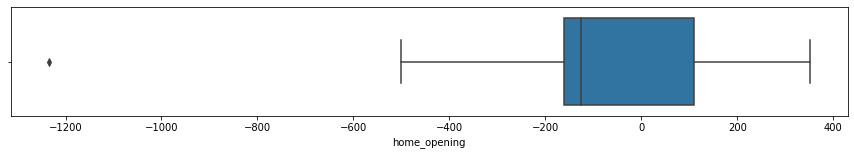

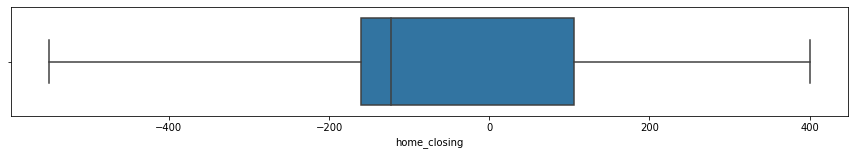

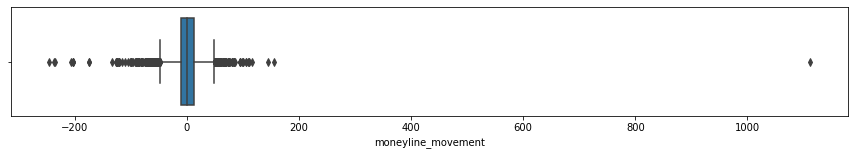

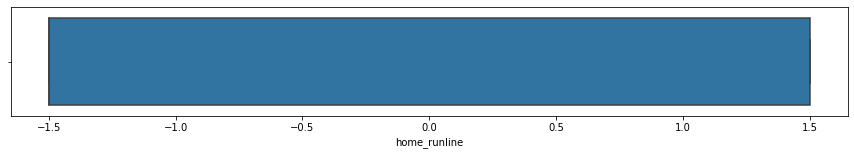

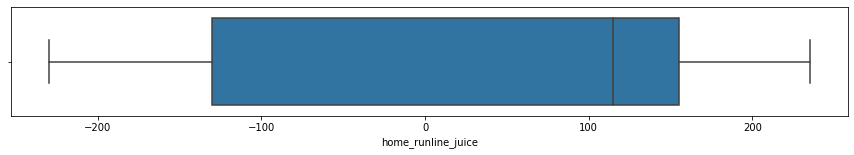

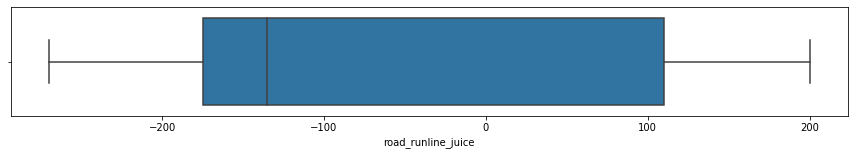

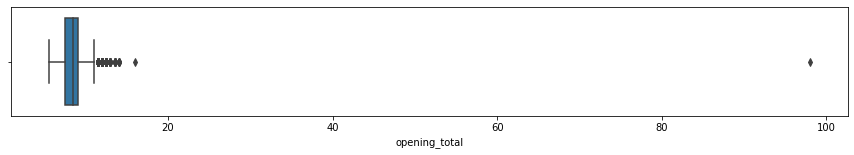

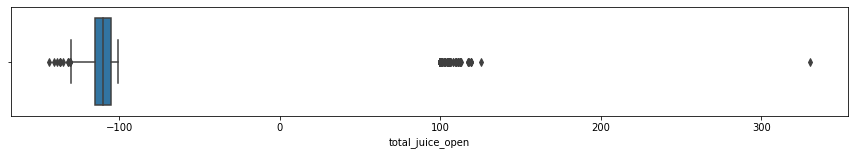

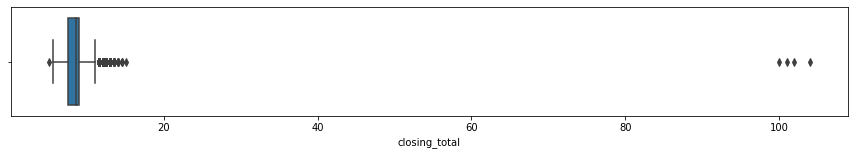

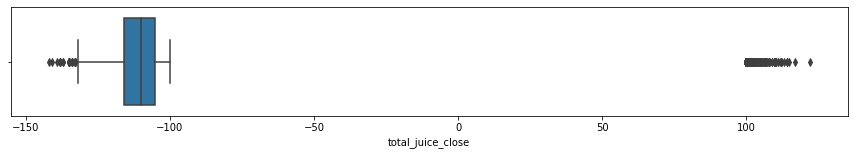

In [51]:
#view odds features
for feature in odds_.columns:
    plt.figure(figsize = (15, 2))
    sns.boxplot(x = odds_[feature])

In [52]:
#look at problem indices
bad_data = odds_[(odds_.home_opening < -1000) | (odds_.moneyline_movement > 1000) |
                (odds_.opening_total > 80) | (odds_.total_juice_open > 300) |
                (odds_.closing_total > 80)]
bad_data

,home_opening,home_closing,moneyline_movement,home_runline,home_runline_juice,road_runline_juice,opening_total,total_juice_open,closing_total,total_juice_close
5810,-125.0,-140.0,-15.0,-1.5,165.0,-185.0,7.5,330.0,7.5,-120.0
10207,110.0,9.5,-100.5,-1.5,176.0,-210.0,9.5,-110.0,104.0,-110.0
10649,120.0,9.5,-110.5,-1.5,176.0,-210.0,8.5,100.0,102.0,-110.0
11690,108.0,-218.0,-126.0,1.5,-169.0,147.0,8.0,-110.0,101.0,-110.0
12007,-106.0,8.0,-86.0,-1.5,177.0,-212.0,8.5,-110.0,100.0,-110.0
12606,-1235.0,-124.0,1111.0,-1.5,160.0,-185.0,9.0,-110.0,8.5,105.0
14172,-110.0,100.0,10.0,-1.5,195.0,-220.0,98.0,-110.0,7.5,-115.0


In [53]:
#retrieve bad data indices 
bad_data_indices = bad_data.index
updated_X = updated_X.drop(bad_data_indices, axis = 0).reset_index(drop = True)
y1 = y1.drop(bad_data_indices)
y2 = y2.drop(bad_data_indices)
y3 = y3.drop(bad_data_indices)

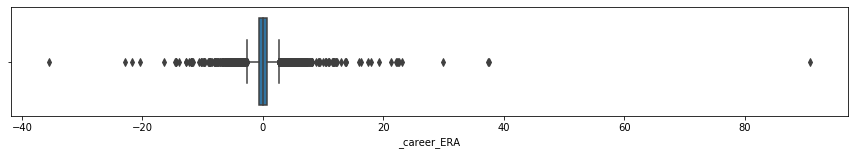

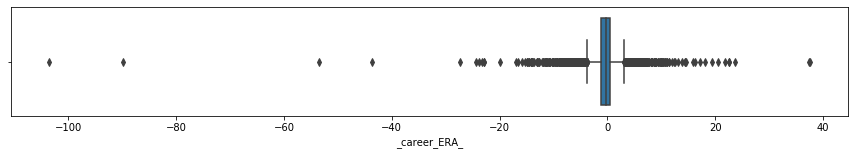

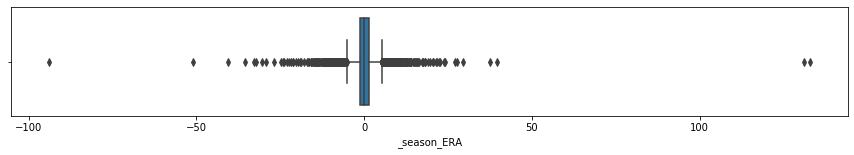

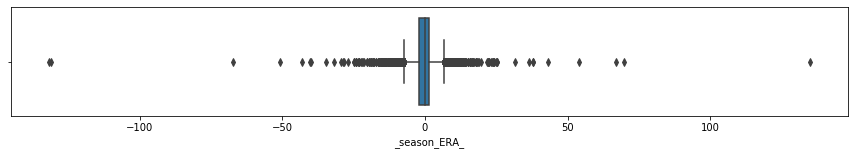

In [55]:
suspect_pitching_features = ['_career_ERA', '_career_ERA_', '_season_ERA', '_season_ERA_' ]
for feature in suspect_pitching_features:
    plt.figure(figsize = (15, 2))
    sns.boxplot(x = updated_X[feature])

In [56]:
problem_indices = set(updated_X[~(updated_X._season_ERA_.between(-40, 40)) |
                           ~(updated_X._season_ERA.between(-40, 40)) | ~(updated_X._career_ERA.between(-25, 25))
                           | ~(updated_X._career_ERA_.between(-25, 25))].index)
updated_X = updated_X.drop(problem_indices, axis = 0).reset_index(drop = True)
y1 = y1.drop(problem_indices)
y2 = y2.drop(problem_indices)
y3 = y3.drop(problem_indices)

In [58]:
new_full = pd.concat([updated_X, y1, y2, y3], axis = 1)
new_full.to_csv('./most_recent.csv.gz', index = False, compression = 'gzip')

In [22]:
full_ = pd.read_csv('./most_recent.csv.gz', compression = 'gzip')
X = full_.drop(columns = ['home_loss', 'home_runline_cover', 'over_hit'])
y1, y2, y3 = full_['home_loss'], full_['home_runline_cover'], full_['over_hit']

In [28]:
X = X.dropna()
y1 = y1.dropna()
y2 = y2.dropna()
y3 = y3.dropna()

In [32]:
new_full = pd.concat([X, y1, y2, y3], axis = 1)
new_full.to_csv('./most_recent.csv.gz', index = False, compression = 'gzip')

In [33]:
new_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14550 entries, 0 to 14549
Data columns (total 61 columns):
_OBPS                         14518 non-null float64
_AVG_RUNS                     14518 non-null float64
_AVG_H                        14518 non-null float64
_BULLPEN_ERA                  14518 non-null float64
_BULLPEN_WHIP                 14518 non-null float64
_BULLPEN_AVG_INNINGS          14518 non-null float64
_total_OBPS                   14518 non-null float64
_total_AVG_RUNS               14518 non-null float64
_total_AVG_H                  14518 non-null float64
_total_BULLPEN_ERA            14518 non-null float64
_total_BULLPEN_WHIP           14518 non-null float64
_total_BULLPEN_AVG_INNINGS    14518 non-null float64
_career_ERA                   14518 non-null float64
_career_WHIP                  14518 non-null float64
_career_AVGIP                 14518 non-null float64
_career_ERA_                  14518 non-null float64
_career_WHIP_                 14518 non-nul

In [34]:
def scale_features(df):
    def get_features_to_scale(df, tol):
        to_scale = []
        all_features = list(df.columns)
        for feature in all_features:
            if df[feature].std() > tol:
                to_scale.append(feature)
        return(to_scale)
    needs_scaling = get_features_to_scale(df, 10.0)
    scale_df = df[needs_scaling]
    df = df.drop(columns = needs_scaling)
    npX = np.array(scale_df)
    ss = StandardScaler()
    npX = ss.fit_transform(npX)
    scaled_df = pd.DataFrame(npX)
    scaled_df.columns = needs_scaling
    df = pd.concat([df, scaled_df], axis = 1)
    return(df)
scaled_X = scale_features(X)

In [45]:
#iterate through features
all_results = []
for target in(y1, y2, y3):
    sampler = SubsetSampler(scaled_X, target, discrepancy_dict, params = {'solver' : 'lbfgs', 'max_iter' : 1000},
                           VIF = True)
    sampler.sample()
    all_results.append(sampler.results_frame)
frame = pd.concat(all_results, axis = 1)
frame.columns = ['category', 'win_loss_score', 'DROP1', 'runline_score', 'DROP2', 'total_score']
frame = frame.drop(columns = ['DROP1', 'DROP2'])
frame

,category,win_loss_score,runline_score,total_score
0,OBPS,0.510912,0.499859,0.500018
1,RUNS,0.512001,0.499413,0.499708
2,HITS,0.501554,0.499492,0.500272
3,STARTER_ERA,0.507291,0.499305,0.499916
4,STARTER_WHIP,0.502401,0.499833,0.500113
5,STARTER_AVGIP,0.508470,0.500082,0.499684
6,BULLPEN_ERA,0.511281,0.499898,0.500270
7,BULLPEN_WHIP,0.513937,0.500034,0.500319
8,BULLPEN_AVGIP,0.506098,0.501641,0.500325
9,ELORatings,0.550285,0.500380,0.500000


In [60]:
sampler = SubsetSampler(scaled_X, y2, discrepancy_dict, algorithm = LGBMClassifier(),
                        params = {'num_leaves' : 70, 'max_depth' : 5, 'n_estimators' : 100})

In [61]:
sampler.feature_search()

In [62]:
sampler.best_feature_set

['home_runline', 'home_runline_juice', 'road_runline_juice']

In [66]:
selector = FeatureSelector(scaled_X, y2, algorithm = LGBMClassifier(),
                          params = {'num_leaves' : 70, 'max_depth' : 5, 'n_estimators' : 100})
selector.recursive_selection()

3 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features have been dropped, moving to next iteration
1 features

'Cannot reduce feature frame anymore. Reduce drop size if desired'

In [68]:
selector.best_subset

Index(['_OBPS', '_AVG_RUNS', '_BULLPEN_ERA', '_BULLPEN_WHIP',
       '_BULLPEN_AVG_INNINGS', '_total_OBPS', '_total_AVG_H',
       '_total_BULLPEN_ERA', '_total_BULLPEN_WHIP',
       '_total_BULLPEN_AVG_INNINGS', '_career_ERA', '_career_ERA_',
       '_career_WHIP_', '_career_AVGIP_', '_season_ERA', '_season_WHIP',
       '_season_AVGIP', '_season_ERA_', '_season_WHIP_', 'pitcher_rgs',
       'elo_prob1', 'rating_prob1', 'pitcher_adj', 'TMAX', 'attendance',
       'run_differential_hm', 'home_closing', 'moneyline_movement',
       'home_runline_juice'],
      dtype='object')

In [10]:
#remove odds 
without_odds = full_.drop(columns = odds_features)
#generate score differential Series, will be used in future model
score_differential = full_.score1 - full_.score2
#prepare dataframe for modeling by removing merge keys 
drop_cols = ['date', 'is_doubleheader', 'is_tripleheader', 'home_starter', 'road_starter', 'team1', 'team2', 
            'elo_prob2', 'rating_prob2', 'home_loss', 'score1', 'score2', 'year']
#generate feature frame 
X = without_odds.drop(columns = drop_cols)
#generate target vector
y = without_odds['home_loss']

In [13]:
#baseline Logistic Regression model 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)
#instantiate Logistic Regression model
lr = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
#fit Logistic Regression model
lr.fit(x_train, y_train)
#generate validation predictions on hold out set
y_preds = lr.predict(x_test)
base_accuracy = accuracy_score(y_test, y_preds)
print('The baseline accuracy is {}'.format(base_accuracy))

The baseline accuracy is 0.5726397800183318


The baseline accuracy is exactly what I expected after the prior research in the __01classificiation_win_loss.ipynb__ notebook. I will run through feature selection and parameter tuning on this reduced dataset, and I will also try the large scale parameters generated in the previous notebook. 

In [15]:
#instantiate FeatureSelector object from recursive_selection.py file
selector = FeatureSelector(X, y, algorithm = LGBMClassifier(), params = {'num_leaves' : 50,
                                                                        'max_depth' : 3}, drop_size = 10)
#iterate through feature selection 
selector.recursive_selection()

'Cannot reduce feature frame anymore. Reduce drop size if desired'

In [18]:
#instantiate FeatureSelector with different parameters
selector = FeatureSelector(X, y, algorithm = LGBMClassifier(), params = {'num_leaves' : 50,
                                                                        'max_depth' : 3}, VIF = True, VIF_tol = 5.0,
                          drop_size = 10)
selector.recursive_selection()

'Cannot reduce feature frame anymore. Reduce drop size if desired'

The performance is no better (in fact it is worse) than the full dataframe. Now I will begin the experimentation with Feature Engineering and adding gambling data.

In [38]:
#bring in best feature set from previous notebook
with open('best_features.json', 'r') as f:
    best_features = json.load(f)
#prepare frame with best features
best_X = updated_X[best_features]

In [44]:
#generate gambling features to add 
gambling_features = ['home_closing', 'home_runline', 'road_closing', 'road_runline']
#concatenate these features to primary dataframe 
best_X = pd.concat([best_X, full_[gambling_features]], axis = 1)
#view info
best_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14545 entries, 0 to 14544
Data columns (total 26 columns):
_OBPS                         14545 non-null float64
_AVG_RUNS                     14545 non-null float64
_BULLPEN_WHIP                 14545 non-null float64
_total_OBPS                   14545 non-null float64
_total_AVG_RUNS               14545 non-null float64
_total_AVG_H                  14545 non-null float64
_total_BULLPEN_WHIP           14545 non-null float64
_total_BULLPEN_AVG_INNINGS    14545 non-null float64
_career_ERA_                  14545 non-null float64
_season_ERA                   14545 non-null float64
_season_AVGIP                 14545 non-null float64
_season_AVGIP_                14545 non-null float64
elo_pre                       14545 non-null float64
rating_pre                    14545 non-null float64
pitcher_rgs                   14545 non-null float64
pitcher_adj                   14545 non-null float64
pitching_park_factor          14545 non-nul

In [50]:
#run FeatureSelector with new gambling features
selector = FeatureSelector(best_X, y, algorithm = LGBMClassifier(), params = {'num_leaves' : 50,
                                                                             'max_depth' : 3},
                          drop_size = 10)
selector.recursive_selection()
#print best evaluation
print('The best evaluation was {}'.format(selector.best_eval))

The best evaluation was 0.5782743210725335


As this evaluation is the best to date, I will proceed with the subset generated from this selection.

In [64]:
#generate final frame 
X_final = best_X[list(selector.best_subset)]
#split into training and test data
xtrain, xtest, ytrain, ytest = train_test_split(X_final, y, test_size = 0.3, random_state = 43)
#load in parameters from parameter tuning research
with open('best_LGB_params.json', 'r') as f:
    best_params = json.load(f)
#instantiate LGBMClassifier with best parameters generated via Hyperopt search
lgb = LGBMClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 150, num_leaves = 50)
#fit the model
lgb.fit(xtrain, ytrain)
#generate predictions using the model 
ypreds = lgb.predict(xtest)
#view accuracy score
lgb_acc = accuracy_score(ytest, ypreds)
print('The accuracy of the LGBMClassifier on the holdout set was {}'.format(lgb_acc))

The accuracy of the LGBMClassifier on the holdout set was 0.576076993583868


There is one more feature I would like to consider and that is the difference between the opening lines and closing lines. This could have predictive power. 

In [67]:
#generate opening/closing differentials 
home_line_diff = full_.home_closing - full_.home_opening
road_line_diff = full_.road_closing - full_.road_opening
#create new dataframe 
X_final = pd.concat([best_X, home_line_diff, road_line_diff], axis = 1)
#split into training and test data
xtrain, xtest, ytrain, ytest = train_test_split(X_final, y, test_size = 0.3, random_state = 43)
#load in parameters from parameter tuning research
with open('best_LGB_params.json', 'r') as f:
    best_params = json.load(f)
#instantiate LGBMClassifier with best parameters generated via Hyperopt search
lgb = LGBMClassifier(learning_rate = 0.1, max_depth = 3, n_estimators = 150, num_leaves = 50)
#fit the model
lgb.fit(xtrain, ytrain)
#generate predictions using the model 
ypreds = lgb.predict(xtest)
#view accuracy score
lgb_acc = accuracy_score(ytest, ypreds)
print('The accuracy of the LGBMClassifier on the holdout set was {}'.format(lgb_acc))

The accuracy of the LGBMClassifier on the holdout set was 0.571494042163153


This did not yield any improvement whatsoever. The next step is looking at what can be done with runline and score differential. 

# 2019 Moneyline Experiment

I have been dealing with modeling using $100$ years of baseball data and randomly selected training and test sets throughout those $100$ years of data. Baseball has changed drastically over the last $100$ years, and my initial theory for how to account for this was to add binary dummy variables for different eras: Deadball, Liveball, Steriod, etc. Perhaps this was not the right way to go about this. I am going to try a much more target experiment: using $5$ years of data to predict a single year, then I will trying using $5$ years of data and the prediction_probability method offered by scikit-learn compatible algorithms to test what the maximum profit that could have been generated from moneyline bets during the $2019$ season.

In [6]:
#create feature frame without odds
X = full_[full_.year < 2019].drop(columns = ['date', 'is_doubleheader', 'is_tripleheader', 'home_starter', 
                                             'road_starter','team1', 'team2', 'elo_prob2', 'rating_prob2', 
                                             'home_loss', 'score1', 'score2', 'year'])
#I will begin with moneyline, which only concerns with wins and losses, then move to run line
y = full_[full_.year < 2019].home_loss

In [7]:
#isolate team features and moneylines
reduced = list(X.columns[:57])
lines = list(X.columns[92:95])
reduced += lines
#take these features from main dataframe
X_reduced = X[reduced]

In [8]:
from recursive_selection import FeatureSelector

In [9]:
selector = FeatureSelector(X_reduced, y, algorithm = LGBMClassifier(), params = {'num_leaves' : 50, 'max_depth' : 3},
                          VIF = True, VIF_tol = 5.0, drop_size = 10)
selector.recursive_selection()

'Cannot reduce feature frame anymore. Reduce drop size if desired'

In [10]:
#isolate features that yielded the best evaluation
features = selector.best_subset

In [11]:
#initalize LGBMClassifier using best parameters (discovered in notebook 01)
LGBM = LGBMClassifier(n_estimators = 150, max_depth = 3, num_leaves = 50)
#fit using previous years of data
LGBM.fit(X[features], y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=3,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=150, n_jobs=-1, num_leaves=50, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [12]:
#get 2019 data to test predicictions on
all_2019 = full_[full_.year == 2019].reset_index(drop = True)
#drop unneeded features
all_2019X = all_2019[features]
#isolate target variable 
all_2019y = all_2019['home_loss']

In [13]:
#get win probabilities
wp_2019 = LGBM.predict_proba(all_2019X)
#take single dimensional array of home win probabilities
home_wp = pd.Series([i[1] for i in wp_2019])
#actual_predictions
preds_2019 = pd.Series(LGBM.predict(all_2019X))

In [14]:
#add probabilities to frame 
with_prob2019 = pd.concat([all_2019, home_wp, preds_2019], axis = 1).rename(columns = {0 : 'road_win_probability',
                                                                                      1 : 'model_prediction'})
#retain only necessary features
with_prob2019 = with_prob2019[['team1', 'team2', 'home_loss', 'score1', 'score2', 'home_opening', 'home_closing',
                              'road_opening', 'road_closing', 'road_win_probability', 'model_prediction']]

In [15]:
#view frame
with_prob2019.head(10)

,team1,team2,home_loss,score1,score2,home_opening,home_closing,road_opening,road_closing,road_win_probability,model_prediction
0,CIN,PIT,0,5.0,3.0,-115.0,-117.0,105.0,107.0,0.449083,0
1,MIL,STL,0,5.0,4.0,-114.0,-114.0,104.0,104.0,0.464498,0
2,PHI,ATL,0,10.0,4.0,-190.0,-185.0,170.0,170.0,0.391707,0
3,FLA,COL,1,3.0,6.0,131.0,125.0,-145.0,-135.0,0.548412,1
4,MIN,CLE,0,2.0,0.0,122.0,-117.0,-135.0,107.0,0.497959,0
5,SDP,SFG,0,2.0,0.0,104.0,-127.0,-114.0,117.0,0.480239,0
6,TOR,DET,1,0.0,2.0,-140.0,-142.0,126.0,132.0,0.399729,0
7,NYY,BAL,0,7.0,2.0,-340.0,-380.0,296.0,320.0,0.395938,0
8,LAD,ARI,0,12.0,5.0,-160.0,-165.0,144.0,155.0,0.417594,0
9,TEX,CHC,1,4.0,12.0,122.0,105.0,-135.0,-115.0,0.507615,1


In [50]:
##NOTE: adding only home / only road capability ?
class BankrollCalculator():
    def __init__(self, df, unit = 100, with_juice = False, use_closing = False, play_levels = 'all', tier1_home = 0.2,
                tier2_home = [0.2, 0.3], tier3_home = [0.3, 0.4], tier1_road = 0.8, tier2_road = [0.7,0.8],
                tier3_road = [0.6, 0.7]):
        self.df = df
        self.unit = unit
        self.with_juice = with_juice
        self.use_closing = use_closing
        self.play_levels = play_levels
        self.tier1_home = tier1_home
        self.tier2_home = tier2_home
        self.tier3_home = tier3_home
        self.tier1_road = tier1_road
        self.tier2_road = tier2_road
        self.tier3_road = tier3_road
        self.total_bankroll = 0
        self.tier1_bankroll = 0
        self.tier2_bankroll = 0
        self.tier3_bankroll = 0
        self.n_plays = 0
        self.frames_dict = {}
    
    def calculate_bankroll(self):
        self.get_plays()
        for key in self.frames_dict.keys():
            outcome = 0
            level, logic = key.split('_')[0], key.split('_')[1]
            if logic == 'home':
                for j in range(len(self.frames_dict[key])):
                    outcome += self.place_bet_home(self.frames_dict[key].iloc[j])
                    self.n_plays += 1
            else:
                for j in range(len(self.frames_dict[key])):
                    outcome += self.place_bet_road(self.frames_dict[key].iloc[j])
                    self.n_plays += 1
            if level == 'tier1':
                self.tier1_bankroll += outcome
            elif level == 'tier2':
                self.tier2_bankroll += outcome
            else:
                self.tier3_bankroll += outcome
        self.total_bankroll = self.tier1_bankroll + self.tier2_bankroll + self.tier3_bankroll
            
    def get_plays(self):
        if self.play_levels == 'all':
            self.frames_dict['tier1_home'] = self.df[self.df.road_win_probability < self.tier1_home]
            self.frames_dict['tier1_road'] = self.df[self.df.road_win_probability > self.tier1_road]
            self.frames_dict['tier2_home'] = self.df[self.df.road_win_probability.\
                                                     between(self.tier2_home[0], self.tier2_home[1])]
            self.frames_dict['tier2_road'] = self.df[self.df.road_win_probability.\
                                                     between(self.tier2_road[0], self.tier2_road[1])]
            self.frames_dict['tier3_home'] = self.df[self.df.road_win_probability.\
                                                     between(self.tier3_home[0], self.tier3_home[1])]
            self.frames_dict['tier3_road'] = self.df[self.df.road_win_probability.\
                                                     between(self.tier3_road[0], self.tier3_road[1])]
        elif self.play_levels == 'best':
            self.frames_dict['tier1_home'] = self.df[self.df.road_win_probability < self.tier1_home]
            self.frames_dict['tier1_road'] = self.df[self.df.road_win_probability > self.tier1_road]
        
        elif self.play_levels == 'top2':
            self.frames_dict['tier1_home'] = self.df[self.df.road_win_probability < self.tier1_home]
            self.frames_dict['tier1_road'] = self.df[self.df.road_win_probability > self.tier1_road]
            self.frames_dict['tier2_home'] = self.df[self.df.road_win_probability.\
                                                     between(self.tier2_home[0], self.tier2_home[1])]
            self.frames_dict['tier2_road'] = self.df[self.df.road_win_probability.\
                                                     between(self.tier2_road[0], self.tier2_road[1])]
    
    
    def place_bet_home(self, obs):
        if self.use_closing:
            line = obs['home_closing']
        else:
            line = obs['home_opening']
        if line > 0:
            line_type = 'dog'
        else:
            line_type = 'fav'
        if obs['model_prediction'] == obs['home_loss']:
            if line_type == 'dog':
                result = (line / 100) * self.unit 
            else:
                if self.with_juice:
                    result = self.unit
                else:
                    result = (100 / abs(line)) * self.unit
        else:
            if line_type == 'dog':
                result = -1 * self.unit
            else:
                if self.with_juice:
                    result = (line / 100) * self.unit
                else:
                    result = -1 * self.unit
        return(result)
    
    def place_bet_road(self, obs):
        if self.use_closing:
            line = obs['road_closing']
        else:
            line = obs['road_opening']
        if line > 0:
            line_type = 'dog'
        else:
            line_type = 'fav'
        if obs['model_prediction'] == obs['home_loss']:
            if line_type == 'dog':
                result = (line / 100) * self.unit
            else:
                if self.with_juice:
                    result = self.unit
                else:
                    result = (100 / abs(line)) * self.unit
        else:
            if line_type == 'dog':
                result = -1 * self.unit
            else:
                if self.with_juice:
                    result = (line / 100) * self.unit
                else:
                    result = -1 * self.unit
        return(result)
                


In [58]:
bc = BankrollCalculator(with_prob2019, with_juice = True)

In [59]:
bc.calculate_bankroll()

In [64]:
bc.total_bankroll

-365.0

In [66]:
bc.tier1_bankroll

465.0

In [49]:
place_bet_home(with_prob2019.iloc[3], False, False, 100)

131.0